## Parabolic PDEs

The simplest parabolic PDE is the 1D diffusion equation. Namely,
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

### Heat Conduction
Heat conduction is a diffusive process.
$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}
$$
where $\alpha$ is the thermal diffusity, $T$ is the temperature.

Discretizing this with FTCS is subject to the following stability constraint:
$$
\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}.
$$

### Probelm Set-up
Say we have a graphite rod, with thermal diffusivity of $\alpha=1.22×10−3\,m^2/s$, length $L=1\,m$, and temperature $T=0\,^\circ C$ everywhere. At time $t=0$, we raise the temperature on the left-side end, $x=0$, to $T=100\,^\circ C$, and hold it there. 

How will the temperature evolve in the rod?

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# set parameters
L = 1.0  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1.22e-3  #  thermal diffusivity of the rod

# define the locations along the rod
x = numpy.linspace(0.0, L, num=nx)

# set the initial temperature along the rod
T0 = numpy.zeros(nx)
T0[0] = 100.0

FTCS discretization

$$
T_{i}^{n+1}=T_{i}^{n}+\frac{\alpha\Delta t}{\Delta x^2}(T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n})
$$

In [4]:
def ftcs(T0, nt, dt, dx, alpha):
    """
    Computes and returns the temperature along the rod after a 
    provided number of time steps, given the initial temperature 
    and thermal diffusivity.
    The diffusion equation is integrated using forward  differencing 
    in time and central differencing in space.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature along the rod as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    alpha : float
        The thermal diffusivity of the rod
    
    Returns
    -------
    T : numpy.ndarray
        The temperature along the rod as a 1D array of floats
    """
    
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
    return T

In [5]:
# set the time-step size based on CFL limit
nt = 100  # number of time steps to compute
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size

# compute the temperature along the rod
T = ftcs(T0, nt, dt, dx, alpha)

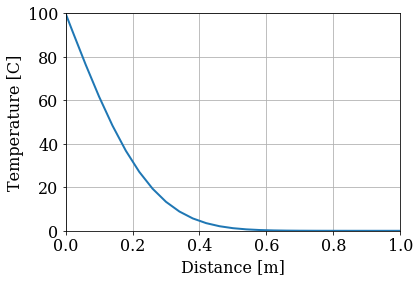

In [6]:
# plot the temperature along the rod
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

### Boundary Conditions
#### Dirichlet BC
Dirichlet BC is where a border is held to a specific value of the solution variable. We imposed a Dirichlet BC on the left side, but nothing on the right side. The solution time is not long enough for this to reach to the right boundary.

Let's see what happens given enough time.

In [7]:
# increase the number of time steps
nt = 1000

# compute the temperature along the rod
T = ftcs(T0, nt, dt, dx, alpha)

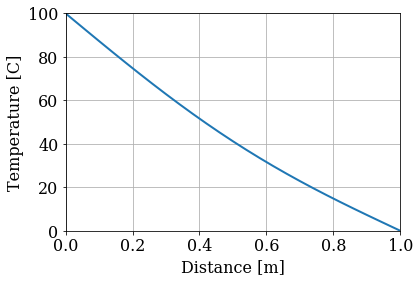

In [8]:
# plot the temperature along the rod
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

FTCS never updates T[-1], which indirectly makes a Dirichlet BC at the right boundary. Because both end temperatures are "pinned" to set values, the temperature distribution within the rod will relax (after enough time) to a linear temperature gradient across the length of the rod.

Once the solution is relaxed, no number of extra time steps will make it change. This is an example of a steady-state solution and we'll learn more about those in Module 5 of the course.

#### Neumann BC
Rather than specifying the value of the solution at the border, they specify the value of the derivative of the solution at the border.

For this example:
$$
\left. \frac{\partial T}{\partial x} \right|_{x = 1} = q(t).
$$

We enforce that using finite-difference discretization of the derivative at the boundary. At time step $n$, for $N$ points, that would be,
$$
\left. \frac{\partial T}{\partial x} \right|_{x=1} \approx \frac{T^n_N - T^n_{N-1}}{\Delta x} = q(t)
$$

For example, if the rod at $x=1$ has some insulating material, no heat is going to be able to get out through that end, and the Neumann boundary condition is:
$$
\left. \frac{\partial T}{\partial x} \right|_{x=1} = 0.
$$

To enforce this at the right hand side,
$$
T[-1]=T[-2].
$$

In [9]:
def ftcs_mixed_bcs(T0, nt, dt, dx, alpha):
    """
    Computes and returns the temperature along the rod after a provided 
    number of time steps, given the initial temperature and the thermal 
    diffusivity. The diffusion equation is integrated using forward 
    differencing in time and central differencing in space. The function 
    uses a Dirichlet condition on the left side of the rod and a Neumann 
    condition (zero-gradient) on the right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature along the rod as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    alpha : float
        The thermal diffusivity of the rod
    
    Returns
    -------
    T : numpy.ndarray
        The temperature along the rod as a 1D array of floats.
    """
    
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
        
        # apply Neumann condition at the last location
        T[-1] = T[-2]
        
    return T

In [10]:
nt = 1000  # number of time steps to compute

# compute the temperature along the rod
T = ftcs_mixed_bcs(T0, nt, dt, dx, alpha)

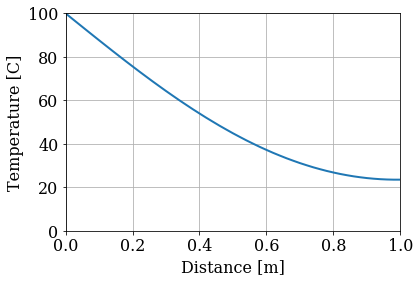

In [11]:
# plot the temperature along the rod
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

### Explicit Schemes and BCs
The numerical schemes we've learned so far are called explicit, because we compute the updated solution at $t^{n+1}$ using only known information at time $t^n$.

### Explicit Schemes and Time Step
Replace $\sigma=\alpha \frac{\Delta t}{(\Delta x)^2}$ and re-arrange to get
$$
T_{i}^{n+1} = \sigma T_{i-1}^{n}+(1- 2 \sigma) T_{i}^{n} + \sigma T_{i+1}^{n}
$$